In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import libarchive.public
import pickle
import random
import Levenshtein

In [2]:
PERCENTAGE = 5

In [3]:
def input_file_size(file_path: Path):
    with libarchive.public.file_reader(str(file_path)) as archive:
        size = 0
        for entry in archive:
            size += entry.size
    return size

In [4]:
input_folder = Path('../../../data/matched-infoboxes-raw')
input_files = list(input_folder.rglob('*.7z'))
len(input_files)

586

In [ ]:
# SAVE change tuples partially on disk.
num_iterations = 100 // PERCENTAGE
for i in range(num_iterations):
    partial_input_files = partial_input_files = input_files[int(len(input_files) / num_iterations * i): int(len(input_files) / num_iterations * (i + 1))]
    print(f'reading {int(len(input_files) / num_iterations * i)} to {int(len(input_files) / num_iterations * (i + 1))}')
    change_tuples = []
    for archive_path in tqdm(partial_input_files):
        with libarchive.public.file_reader(str(archive_path)) as archive:
            for entry in archive:
                content_bytes = bytearray('', encoding='utf_8')
                for block in entry.get_blocks():
                    content_bytes += block
                content = content_bytes.decode(encoding='utf_8')
                jsonObjs = content.split('\n')
                for jsonObj in filter(lambda x: x, jsonObjs):
                    obj = json.loads(jsonObj)
                    title = obj['pageTitle']
                    subject = obj['pageID']
                    changes = obj['changes']
                    valid_from = obj['validFrom']
                    for change in changes:
                        current_value = change['currentValue'] if 'currentValue' in change.keys() else None
                        previous_value = change['previousValue'] if 'previousValue' in change.keys() else None
                        name = change['property']['name']
                        valid_to = change['valueValidTo'] if 'valueValidTo' in change.keys() else None
                        change_tuples.append((subject, title, name, previous_value, current_value, valid_from, valid_to))
    
    print('writing file')
    with open(f'../../../data/raw_change_tuples/partial_change_tuples_part_{i}.pickle', 'wb') as file:
        pickle.dump(change_tuples, file)
    print('successfully wrote file')

reading 0 to 29


100%|██████████| 29/29 [02:36<00:00,  5.38s/it]


writing file
successfully wrote file
reading 29 to 58


 31%|███       | 9/29 [00:52<01:58,  5.92s/it]

In [5]:
with open(f'../../../data/raw_change_tuples/partial_change_tuples_part_{0}.pickle', 'rb') as file:
        change_tuples = pickle.load(file)

In [6]:
data = pd.DataFrame(change_tuples, columns=['subject', 'title', 'name', 'previous_value', 'current_value', 'valid_from', 'valid_to'])
del change_tuples
data['valid_from'] = pd.to_datetime(data['valid_from'])
data['valid_to'] = pd.to_datetime(data['valid_to'])
data['valid_time'] = data['valid_to'] - data['valid_from']
data

In [7]:
data

,subject,title,name,previous_value,current_value,valid_from,valid_to,valid_time
0,58839507,Smita Thackeray,image,None,Smita Thackeray.jpg,2018-10-21 13:21:34+00:00,2018-12-26 19:56:22+00:00,66 days 06:34:48
1,58839507,Smita Thackeray,birth_place,None,"[[Mumbai]], [[Maharashtra]], [[India]]",2018-10-21 13:21:34+00:00,NaT,NaT
2,58839507,Smita Thackeray,nationality,None,[[India]]n,2018-10-21 13:21:34+00:00,NaT,NaT
3,58839507,Smita Thackeray,children,None,Rahul Thackeray <ref>{{cite web |title=Bollywo...,2018-10-21 13:21:34+00:00,2018-10-23 07:54:07+00:00,1 days 18:32:33
4,58839507,Smita Thackeray,parents,None,Madhukar Chitre <br> Kunda Chitre,2018-10-21 13:21:34+00:00,NaT,NaT
...,...,...,...,...,...,...,...,...
15500755,4159282,Spotswood (film),released,{{flagicon|Australia}} 23 January 1992,{{Film date|1992|01|23|df=y}},2016-01-15 05:27:55+00:00,NaT,NaT
15500756,4159282,Spotswood (film),starring,[[Anthony Hopkins]]<br>[[Ben Mendelsohn]]<br>[...,{{plainlist|\n* [[Anthony Hopkins]]\n* [[Ben M...,2016-07-05 13:50:53+00:00,NaT,NaT
15500757,4159282,Spotswood (film),writer,"Max Dann, [[Andrew Knight (writer)|Andrew Knig...",Max Dann<br>[[Andrew Knight (writer)|Andrew Kn...,2016-12-01 22:38:40+00:00,NaT,NaT
15500758,4159282,Spotswood (film),distributor,,[[Miramax]],2017-08-14 08:13:00+00:00,NaT,NaT


Text(0, 0.5, 'Valid time, log')

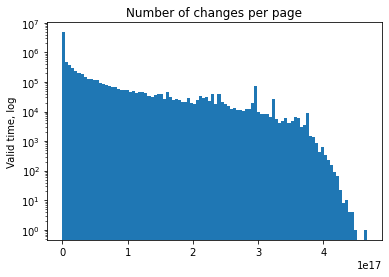

In [22]:
valid_times = data['valid_time'][data['valid_time'].notnull()].to_numpy().astype('int64')
plt.hist(valid_times, bins=100)
plt.yscale('log')
plt.title("Number of changes per page")
plt.ylabel("Valid time, log")

In [ ]:
counted_changes = {}
for archive_path in tqdm(input_files):
    with libarchive.public.file_reader(str(archive_path)) as archive:
        for entry in archive:
            content_bytes = bytearray('', encoding='utf_8')
            for block in entry.get_blocks():
                content_bytes += block
            content = content_bytes.decode(encoding='utf_8')
            jsonObjs = content.split('\n')
            for jsonObj in filter(lambda x: x, jsonObjs):
                obj = json.loads(jsonObj)
                subject = obj['pageTitle']
                changes = obj['changes']
                timestamp = obj['validFrom']
                if subject not in counted_changes.keys():
                    counted_changes[subject] = {}
                curr_counted_changes = counted_changes[subject]
                for change in changes:
                    name = change['property']['name']
                    curr_counted_changes[name] = curr_counted_changes[name] + 1 if name in curr_counted_changes.keys() else 1

In [ ]:
change_tuples = []
for archive_path in tqdm(partial_input_files):
    with libarchive.public.file_reader(str(archive_path)) as archive:
        for entry in archive:
            content_bytes = bytearray('', encoding='utf_8')
            for block in entry.get_blocks():
                content_bytes += block
            content = content_bytes.decode(encoding='utf_8')
            jsonObjs = content.split('\n')
            for jsonObj in filter(lambda x: x, jsonObjs):
                obj = json.loads(jsonObj)
                subject = obj['pageTitle']
                changes = obj['changes']
                timestamp = obj['validFrom']
                for change in changes:
                    current_value = change['currentValue'] if 'currentValue' in change.keys() else None
                    previous_value = change['previousValue'] if 'previousValue' in change.keys() else None
                    name = change['property']['name']
                    change_tuples.append((subject, name, previous_value, current_value, timestamp))

In [ ]:
num_edits = 0
change_tuples = []
for file in tqdm(files[:50]):
    with open(file, 'r', encoding='utf-8') as f:
        for jsonObj in f:
            single_edit = json.loads(jsonObj)
            num_edits += 1
            #entries.append(single_edit)
            title = single_edit['pageTitle']
            changes = single_edit['changes']
            timestamp = single_edit['validFrom']
            for change in changes:
                name = change['property']['name']
                current_value = change['currentValue'] if 'currentValue' in change.keys() else None
                previous_value = change['previousValue'] if 'previousValue' in change.keys() else None
                change_tuples.append((title, name, previous_value, current_value, timestamp))
print(num_edits) # 1934309 for 50
len(change_tuples) # 9715201 for 50

NameError: name 'files' is not defined

In [ ]:
# Analyse Size of Changes

In [5]:
# SAVE change tuples partially on disk.
num_iterations = 100 // PERCENTAGE
for i in range(num_iterations):
    partial_input_files = partial_input_files = input_files[int(len(input_files) / num_iterations * i): int(len(input_files) / num_iterations * (i + 1))]
    print(f'reading {int(len(input_files) / num_iterations * i)} to {int(len(input_files) / num_iterations * (i + 1))}')
    change_tuples = []
    for archive_path in tqdm(partial_input_files):
        with libarchive.public.file_reader(str(archive_path)) as archive:
            for entry in archive:
                content_bytes = bytearray('', encoding='utf_8')
                for block in entry.get_blocks():
                    content_bytes += block
                content = content_bytes.decode(encoding='utf_8')
                jsonObjs = content.split('\n')
                for jsonObj in filter(lambda x: x, jsonObjs):
                    obj = json.loads(jsonObj)
                    title = obj['pageTitle']
                    subject = obj['pageID']
                    changes = obj['changes']
                    valid_from = obj['validFrom']
                    for change in changes:
                        current_value = change['currentValue'] if 'currentValue' in change.keys() else None
                        previous_value = change['previousValue'] if 'previousValue' in change.keys() else None
                        name = change['property']['name']
                        valid_to = change['valueValidTo'] if 'valueValidTo' in change.keys() else None
                        change_tuples.append((subject, title, name, previous_value, current_value, valid_from, valid_to))
    
    print('writing file')
    with open(f'../../../data/raw_change_tuples/partial_change_tuples_part_{i}.pickle', 'wb') as file:
        pickle.dump(change_tuples, file)
    print('successfully wrote file')ta/raw_change_tuples/partial_change_tuples_part_{0}.pickle', 'rb') as file:
        change_tuples = pickle.load(file)

In [6]:
data = pd.DataFrame(change_tuples, columns=['subject', 'title', 'name', 'previous_value', 'current_value', 'valid_from', 'valid_to'])
del change_tuples
data['valid_from'] = pd.to_datetime(data['valid_from'])
data['valid_to'] = pd.to_datetime(data['valid_to'])
data['valid_time'] = data['valid_to'] - data['valid_from']
data['valid_time'] = data['valid_time'] / np.timedelta64(1, 's')


In [7]:
del data['title']
del data['name']
del data['valid_from']
del data['valid_to']

In [8]:
# data['change_size'] = data[['previous_value', 'current_value']].agg(lambda x:print(x.__class__), axis=1)
data['change_size'] = data['previous_value'].combine(data['current_value'], lambda x, y: Levenshtein.distance(x, y) if x and y else None, fill_value=None)

In [10]:
data.sort_values(by=['valid_time'], inplace=True)

In [11]:
def seconds_to_day(sec):
    return sec / (60 * 60 * 24)

def day_to_seconds(sec):
    return sec * (60 * 60 * 24)

In [12]:
valid_time = seconds_to_day(data['valid_time'].dropna().to_numpy())
valid_time.min(), valid_time.max(), valid_time.mean(), valid_time.std()

(0.0, 5394.290543981481, 474.5231526381266, 859.7989578742371)

Text(0, 0.5, '#Occurances, log')

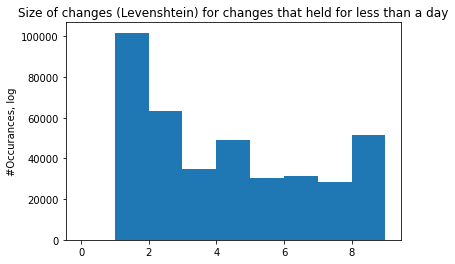

In [20]:
recent_changes = data[data['valid_time'] <= day_to_seconds(1)]
plt.hist(recent_changes['change_size'].to_numpy(), bins=list(range(20)))
plt.title("Size of changes (Levenshtein) for changes that held for less than a day")
plt.ylabel("#Occurances, log")

In [19]:
data[data['change_size'] <= 0]

,subject,previous_value,current_value,valid_time,change_size


Text(0, 0.5, '#Occurances, log')

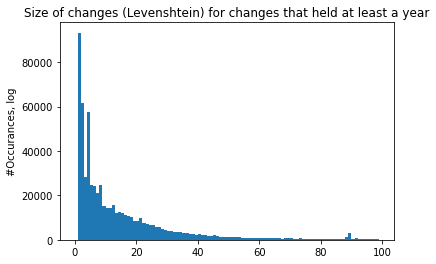

In [21]:
recent_changes = data[data['valid_time'] >= day_to_seconds(356)]
plt.hist(recent_changes['change_size'].to_numpy(), bins=list(range(100)))
plt.title("Size of changes (Levenshtein) for changes that held at least a year")
plt.ylabel("#Occurances, log")

In [ ]:
# File Tests

In [5]:
# Does ['property']['type'] have another value as 'attribute'
types = set()
for archive_path in tqdm(input_files):
    with libarchive.public.file_reader(str(archive_path)) as archive:
        for entry in archive:
            content_bytes = bytearray('', encoding='utf_8')
            for block in entry.get_blocks():
                content_bytes += block
            content = content_bytes.decode(encoding='utf_8')
            jsonObjs = content.split('\n')
            for jsonObj in filter(lambda x: x, jsonObjs):
                obj = json.loads(jsonObj)
                changes = obj['changes']
                for change in changes:
                    prop_type = change['property']['type']
                    types.add(prop_type)
types

100%|██████████| 586/586 [42:09<00:00,  4.32s/it] 


{'attribute', 'meta'}

In [ ]:
# How many numeric values
numeric = 0
string = 0
numeric_to_string = 0
string_to_numeric = 0
for archive_path in tqdm(input_files):
    with libarchive.public.file_reader(str(archive_path)) as archive:
        for entry in archive:
            content_bytes = bytearray('', encoding='utf_8')
            for block in entry.get_blocks():
                content_bytes += block
            content = content_bytes.decode(encoding='utf_8')
            jsonObjs = content.split('\n')
            for jsonObj in filter(lambda x: x, jsonObjs):
                obj = json.loads(jsonObj)
                changes = obj['changes']
                for change in changes:
                    curr_val_number = None
                    prev_val_number = None
                    if 'previousValue' in change:
                        try:
                            float(change['previousValue'])
                            prev_val_number = True
                        except ValueError:
                            prev_val_number = False
                    if 'currentValue' in change:iterate
                        try:
                            float(change['currentValue'])
                            curr_val_number = True
                        except ValueError:
                            curr_val_number = False
                    if curr_val_number is not None:
                        numeric += int(curr_val_number)
                        string += int(not curr_val_number)
                        if prev_val_number is not None:
                            if curr_val_number and not prev_val_number:
                                string_to_numeric += 1
                            if not curr_val_number and prev_val_number:
                                numeric_to_string += 1
                                    
print(f'numeric: {numeric} \t\t % {numeric / (numeric + string)}')
print(f'string: {string} \t\t % {string / (numeric + string)}')
print('\n\nType Changes\n\n')
print(f'numeric to string: {numeric_to_string} \t\t % {numeric_to_string / (numeric + string)}')
print(f'string to numeric: {string_to_numeric} \t\t % {string_to_numeric / (numeric + string)}')

In [ ]:
# Analyse bot reverts

In [5]:
partial_input_files = partial_input_files = input_files[: int(len(input_files) * (PERCENTAGE / 100))]
change_tuples = []
for archive_path in tqdm(partial_input_files):
    with libarchive.public.file_reader(str(archive_path)) as archive:
        for entry in archive:
            content_bytes = bytearray('', encoding='utf_8')
            for block in entry.get_blocks():
                content_bytes += block
            content = content_bytes.decode(encoding='utf_8')
            jsonObjs = content.split('\n')
            for jsonObj in filter(lambda x: x, jsonObjs):
                obj = json.loads(jsonObj)
                key = obj['key']
                revisionID = obj['revisionId']
                valid_from = obj['validFrom']
                changes = obj['changes']
                for change in changes:
                    current_value = change['currentValue'] if 'currentValue' in change.keys() else None
                    previous_value = change['previousValue'] if 'previousValue' in change.keys() else None
                    name = change['property']['name']
                    valid_to = change['valueValidTo'] if 'valueValidTo' in change.keys() else None
                    change_tuples.append((key, revisionID, name, previous_value, current_value, valid_from, valid_to))

print('writing file')
with open(f'../../../data/raw_change_tuples/partial_change_tuples_part_key_{0}.pickle', 'wb') as file:
    pickle.dump(change_tuples, file)

100%|██████████| 29/29 [02:36<00:00,  5.40s/it]


writing file


In [5]:
with open(f'../../../data/raw_change_tuples/partial_change_tuples_part_key_{0}.pickle', 'rb') as file:
        change_tuples = pickle.load(file)

In [6]:
data = pd.DataFrame(change_tuples, columns=['key', 'revisionId', 'name', 'previous_value', 'current_value', 'valid_from', 'valid_to'])
del change_tuples
data['valid_from'] = pd.to_datetime(data['valid_from'])
data['valid_to'] = pd.to_datetime(data['valid_to'])
data['valid_time'] = data['valid_to'] - data['valid_from']
data['valid_time'] = data['valid_time'] / np.timedelta64(1, 's')

In [ ]:
groups = data.groupby(by=['key', 'revisionId', 'name'])
groups.filter(lambda x: x.shape[0] > 1)

In [ ]:
for key, values in list(groups.groups.iteritems())[:20]:
    print(df.ix[values], "\n\n")

In [ ]:
groups.describe()

In [ ]:
# Analyse Creations and Deletions

In [6]:
with open(input_folder.joinpath('change_sizes.pickle'), 'rb') as file:
    change_sizes = pickle.load(file)

Text(0, 0.5, '#Occurances')

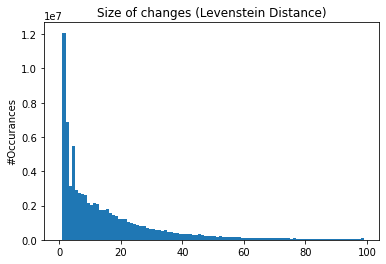

In [14]:
change_sizes = np.array(change_sizes)
plt.hist(np.array(change_sizes), bins=list(range(100)))
#plt.yscale('log')
plt.title("Size of changes (Levenstein Distance)")
plt.ylabel("#Occurances")

In [15]:
change_sizes.min(), change_sizes.max(), change_sizes.mean(), change_sizes.std()

(1, 1371692, 25.681415443426022, 744.5005279287761)

# Analyse changes

Text(0, 0.5, '#Occurances, log')

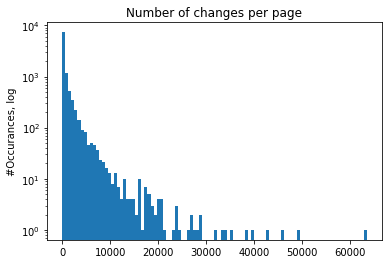

In [30]:
changes_per_page = data.groupby(['title'])['timestamp'].count()
plt.hist(changes_per_page.to_numpy(), bins=100)
plt.yscale('log')
plt.title("Number of changes per page")
plt.ylabel("#Occurances, log")

Text(0, 0.5, '#Occurances, log')

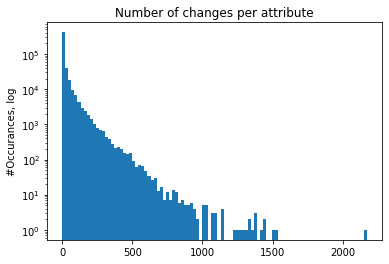

In [31]:
changes_per_attribute = data.groupby(['title', 'name'])['timestamp'].count()
plt.hist(changes_per_attribute.to_numpy(), bins=100)
plt.yscale('log')
plt.title("Number of changes per attribute")
plt.ylabel("#Occurances, log")

In [53]:
data_with_agg = data.join(changes_per_page, on='title', rsuffix='_r').rename(columns={'timestamp_r': 'changes_per_page'})
data_with_agg = data_with_agg.join(changes_per_attribute, on=['title', 'name'], rsuffix='_r').rename(columns={'timestamp_r': 'changes_per_attribute'})

In [54]:
data_with_agg.sort_values('changes_per_attribute')

,title,name,previous_value,current_value,timestamp,changes_per_page,changes_per_attribute
7774519,OS/390,version of,None,,2019-06-20 11:30:14+00:00,40,1
2757766,Abu al-Faraj al-Isfahani,education,None,,2015-11-02 20:29:31+00:00,50,1
3814937,Pope Honorius I,caption,None,Mosaic of Pope Honorius I - Sant'Agnese fuori ...,2017-10-27 03:37:11+00:00,66,1
2757765,Abu al-Faraj al-Isfahani,doctoral_advisor,None,,2015-11-02 20:29:31+00:00,50,1
2757764,Abu al-Faraj al-Isfahani,thesis_title,None,,2015-11-02 20:29:31+00:00,50,1
...,...,...,...,...,...,...,...
4608475,System of a Down,genre,"[[alternative metal]],[[avant-garde music|expe...","[[Rock music|Rock]], [[Heavy metal music|heavy...",2009-08-18 06:07:22+00:00,8886,2170
4608476,System of a Down,genre,"[[Rock music|Rock]], [[Heavy metal music|heavy...","[[Alternative metal]], [[Experimental metal]]",2009-09-02 18:02:45+00:00,8886,2170
4608477,System of a Down,genre,"[[Alternative metal]], [[Experimental metal]]","[[Alternative metal]], [[Experimental music|Ex...",2009-09-02 18:04:58+00:00,8886,2170
4608468,System of a Down,genre,"[[Alternative metal]], [[Heavy metal music|hea...","[[Rock music|Rock]], [[Heavy metal music|heavy...",2009-08-09 18:40:15+00:00,8886,2170
